### Eluvio DS Challenege

__Problem statement__: Forecast, the number of upvotes against certain news based on historic statistics.

-Based on some original features and some derived features, determine that the news will obtain how many upvotes so that author and the publisher can know when and whose posts should be published.

-Topic modeling, e.g., Modelled as regression problem by taking the obtained upvotes as the label during training.

-PCR regressor, Linear regression, Decision tree regressor, and KNN are trained on the dataset with 75% data for training and 25% for the validation.

__What I did in the notebook__:
-  __1) Data Cleaning :__
Removed the unnecessary features based on the categorical and numerical analysis as well as through data exploration. 
- __2) Feature  scaling and transformation:__
Feature values are scaled to maintain a standard, and new features are extracted from the given features.  
 
- __3) Visualization:__ 
Through various line graphs, histograms, and heatmap, data exploration is performed.
- __4) PCA:__
Applied principal component analysis and grid search to optimize the models  

- __5) Forecasting:__
Regression models: PCR regressor, linear regression, lasso regression as the baseline models.
__Evaluation Metrics__: Regression: MSE, R2 score, and RMSE the training and test set.




### Load the required packages

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import re
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from contextlib import contextmanager

from sklearn.preprocessing import scale

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

import nltk
nltk.download('stopwords')
import seaborn as sns
from numpy import mean
from sklearn.metrics import mean_squared_error,r2_score
from sklearn import model_selection
import time
from geotext import GeoText
import re
from collections import Counter
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from datetime import datetime, timedelta, date

nltk.download('punkt')

import warnings
warnings.filterwarnings('ignore')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tharun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/tharun/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Read the dataset

In [49]:
df = pd.read_csv('Eluvio_DS_Challenge.csv')

In [50]:
df.head()# returns first 5 rows of data.

,time_created,date_created,up_votes,down_votes,title,over_18,author,category
0,1201232046,2008-01-25,3,0,Scores killed in Pakistan clashes,False,polar,worldnews
1,1201232075,2008-01-25,2,0,Japan resumes refuelling mission,False,polar,worldnews
2,1201232523,2008-01-25,3,0,US presses Egypt on Gaza border,False,polar,worldnews
3,1201233290,2008-01-25,1,0,Jump-start economy: Give health care to all,False,fadi420,worldnews
4,1201274720,2008-01-25,4,0,Council of Europe bashes EU&UN terror blacklist,False,mhermans,worldnews


In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509236 entries, 0 to 509235
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   time_created  509236 non-null  int64 
 1   date_created  509236 non-null  object
 2   up_votes      509236 non-null  int64 
 3   down_votes    509236 non-null  int64 
 4   title         509236 non-null  object
 5   over_18       509236 non-null  bool  
 6   author        509236 non-null  object
 7   category      509236 non-null  object
dtypes: bool(1), int64(3), object(4)
memory usage: 27.7+ MB


### Count the unique values in each feature of the whole dataset

In [52]:
df.nunique()

time_created    508329
date_created      3223
up_votes          5782
down_votes           1
title           500720
over_18              2
author           85838
category             1
dtype: int64

In [53]:
len(df)

509236

### graph to see the distribution of the feature : Over_18

False    508916
True        320
Name: over_18, dtype: int64


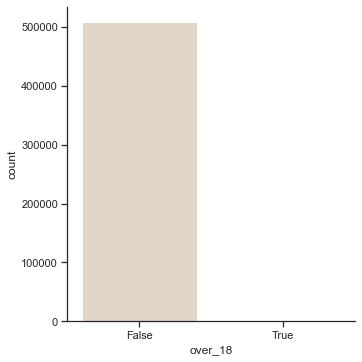

In [54]:
sns.set_theme(style="ticks", color_codes=True)
sns.catplot(x="over_18", kind="count", palette="ch:.25", data=df.sort_values("over_18"))
item_counts = df["over_18"].value_counts()
print(item_counts)

### Density graph to see the distribution of up votes

####  97 is chosen after testing with various values.

<AxesSubplot:xlabel='up_votes', ylabel='Density'>

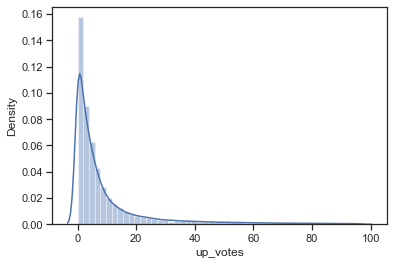

In [55]:
sns.distplot(df[df['up_votes']<=97]['up_votes'])

<AxesSubplot:xlabel='up_votes', ylabel='Density'>

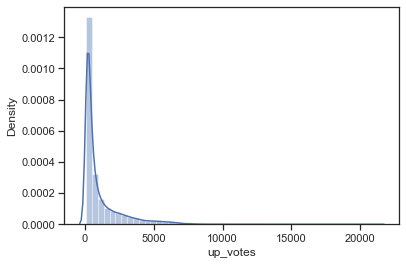

In [56]:
sns.distplot(df[df['up_votes']>97]['up_votes'])

In [57]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

# Feature transformation and extraction 

In [58]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))
    
def countries(x):# get the invidual cities
    count = GeoText(x).countries
    city = GeoText(x).cities
    w = ''
    if not count and not city:
        return np.nan
    else:
        for country in count:
            w = w+' '+country
        for c in city:
            w = w+' '+c
        return w

def places(x):
    count = GeoText(x).countries
    city = GeoText(x).cities
    w = 0
    if not count and not city:
        return 0
    else:
        w=len(count)+len(city)
        return w 

def df_feature_engineer(df):
    df['date_created'] = pd.to_datetime(df['date_created'])
    df['day_of_week']=df['date_created'].dt.day_name()
    df['day_of_week_num']=df['date_created'].dt.dayofweek
    df['year'] = df['date_created'].dt.year
    df['month'] = df['date_created'].dt.month
    df['day'] = df['date_created'].dt.day
    df['weekend'] = np.where(df['date_created'].dt.dayofweek>4, 1, 0)
    df['years_to_now'] = (datetime.today() - df['date_created']).dt.days/365
    # Unix time starts at 00:00:00 Thursday, 1 January 1970
    df['time_created'] = pd.to_datetime(df['time_created'], unit='s')
    df['day_time']=df['time_created'].dt.hour+df['time_created'].dt.minute/60+df['time_created'].dt.second/3600
    df['author_total_posts'] = df['author'].groupby(df['author']).transform('count')
    df = df.drop(columns=['date_created','down_votes','category'])
    df['title_length'] = df['title'].str.split().apply(len)
    df['over_18'] = df['over_18'].map({False:0,True:1})
    df['places'] = df['title'].apply(lambda x: places(x))
    return df

In [59]:
with timer("Transformed features"):
    df = df_feature_engineer(df)

Transformed features - done in 12s


In [60]:
df.head()

,time_created,up_votes,title,over_18,author,day_of_week,day_of_week_num,year,month,day,weekend,years_to_now,day_time,author_total_posts,title_length,places
0,2008-01-25 03:34:06,3,Scores killed in Pakistan clashes,0,polar,Friday,4,2008,1,25,0,13.241096,3.568333,50,5,1
1,2008-01-25 03:34:35,2,Japan resumes refuelling mission,0,polar,Friday,4,2008,1,25,0,13.241096,3.576389,50,4,1
2,2008-01-25 03:42:03,3,US presses Egypt on Gaza border,0,polar,Friday,4,2008,1,25,0,13.241096,3.700833,50,6,2
3,2008-01-25 03:54:50,1,Jump-start economy: Give health care to all,0,fadi420,Friday,4,2008,1,25,0,13.241096,3.913889,2,7,0
4,2008-01-25 15:25:20,4,Council of Europe bashes EU&UN terror blacklist,0,mhermans,Friday,4,2008,1,25,0,13.241096,15.422222,1,7,0


### Drop the useless features

In [61]:
df = df.drop("time_created", axis = 1) # drop the time feature as it is not giving any information
df = df.drop("year", axis = 1) # drop the year feature becaue it is not directly related
df = df.drop("years_to_now", axis = 1)
df = df.drop("title", axis=1)
df = df.drop("author", axis=1)


In [62]:
df.head()

,up_votes,over_18,day_of_week,day_of_week_num,month,day,weekend,day_time,author_total_posts,title_length,places
0,3,0,Friday,4,1,25,0,3.568333,50,5,1
1,2,0,Friday,4,1,25,0,3.576389,50,4,1
2,3,0,Friday,4,1,25,0,3.700833,50,6,2
3,1,0,Friday,4,1,25,0,3.913889,2,7,0
4,4,0,Friday,4,1,25,0,15.422222,1,7,0


### Numeric data analysis

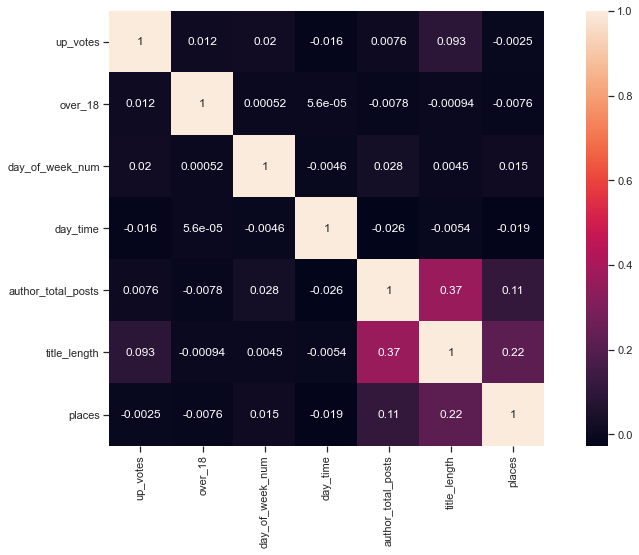

In [63]:
numericVar = ["up_votes","over_18","day_of_week_num","day_time","author_total_posts","title_length","places"]
corrmat = df[numericVar].corr() 
plt.subplots(figsize=(15,8))
sns.heatmap(corrmat, annot=True, vmax=1, square=True);

#title_length and author_total_post are highly correlated --> 0.37
#place and title length are  correlated --> 0.21
#Rooms and Bedroom2 are highly correlated --> 0.95
#rest of the features have either small negative corrleation  or no systematic corrleation

### Categorical Data Analysis

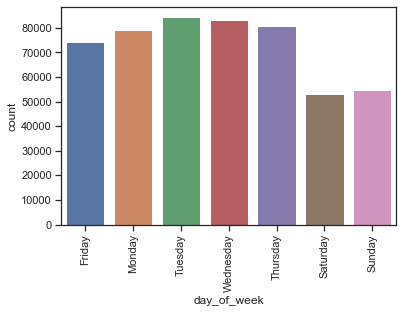

Tuesday      84227
Wednesday    83160
Thursday     80601
Monday       79194
Friday       74183
Sunday       54893
Saturday     52978
Name: day_of_week, dtype: int64




In [64]:
#Sunday and saturday have less news item while rest of the days have more or less equal number of news items
cat_var = ['day_of_week']
for i in cat_var:
    sns.countplot(x=i, data=df)
    plt.xticks(rotation=90)
    plt.show()
    print(df[i].value_counts())
    print('\n')

In [65]:
# no null value are present now
print(len(df))
df.isnull().sum()

509236


up_votes              0
over_18               0
day_of_week           0
day_of_week_num       0
month                 0
day                   0
weekend               0
day_time              0
author_total_posts    0
title_length          0
places                0
dtype: int64

### one hotencoding for the categorical features

In [66]:
# get the dumy values against each unique categorical values
df_day_week =pd.get_dummies(df, columns = ["day_of_week"],prefix=["Day_of_week_is"])


df_final = pd.concat([df,df_day_week], axis=1)# joined the dataet with dumy fetaure
df_final = df_final.loc[:,~df_final.columns.duplicated()]# duplicate the features
df_final = df_final.drop(["day_of_week"],axis=1)


### Dataset statistics after all the preporcessing

In [67]:
df_final.describe().T # give data statistics

,count,mean,std,min,25%,50%,75%,max
up_votes,509236.0,112.236283,541.694675,0.0,1.000000,5.000000,16.000000,21253.000000
over_18,509236.0,0.000628,0.025060,0.0,0.000000,0.000000,0.000000,1.000000
day_of_week_num,509236.0,2.716481,1.917323,0.0,1.000000,3.000000,4.000000,6.000000
month,509236.0,6.457293,3.395653,1.0,3.000000,6.000000,9.000000,12.000000
day,509236.0,15.748616,8.762334,1.0,8.000000,16.000000,23.000000,31.000000
weekend,509236.0,0.211829,0.408605,0.0,0.000000,0.000000,0.000000,1.000000
day_time,509236.0,13.607797,6.127990,0.0,9.405556,14.293472,18.372778,23.999444
author_total_posts,509236.0,659.805823,1531.105563,1.0,7.000000,62.000000,438.000000,8897.000000
title_length,509236.0,14.439048,9.881765,1.0,8.000000,11.000000,16.000000,64.000000
places,509236.0,0.660248,0.783887,0.0,0.000000,1.000000,1.000000,17.000000


In [68]:
df_test = df_final.dropna()## drop the nan values

In [69]:
df_test.head()

,up_votes,over_18,day_of_week_num,month,day,weekend,day_time,author_total_posts,title_length,places,Day_of_week_is_Friday,Day_of_week_is_Monday,Day_of_week_is_Saturday,Day_of_week_is_Sunday,Day_of_week_is_Thursday,Day_of_week_is_Tuesday,Day_of_week_is_Wednesday
0,3,0,4,1,25,0,3.568333,50,5,1,1,0,0,0,0,0,0
1,2,0,4,1,25,0,3.576389,50,4,1,1,0,0,0,0,0,0
2,3,0,4,1,25,0,3.700833,50,6,2,1,0,0,0,0,0,0
3,1,0,4,1,25,0,3.913889,2,7,0,1,0,0,0,0,0,0
4,4,0,4,1,25,0,15.422222,1,7,0,1,0,0,0,0,0,0


In [70]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 509236 entries, 0 to 509235
Data columns (total 17 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   up_votes                  509236 non-null  int64  
 1   over_18                   509236 non-null  int64  
 2   day_of_week_num           509236 non-null  int64  
 3   month                     509236 non-null  int64  
 4   day                       509236 non-null  int64  
 5   weekend                   509236 non-null  int64  
 6   day_time                  509236 non-null  float64
 7   author_total_posts        509236 non-null  int64  
 8   title_length              509236 non-null  int64  
 9   places                    509236 non-null  int64  
 10  Day_of_week_is_Friday     509236 non-null  uint8  
 11  Day_of_week_is_Monday     509236 non-null  uint8  
 12  Day_of_week_is_Saturday   509236 non-null  uint8  
 13  Day_of_week_is_Sunday     509236 non-null  u

### Sampling and splitting the dataset into training and testing set with 75% and 25% respectively

In [82]:
df_test = df_test.sample(frac=1).reset_index(drop=True)
y= df_test["up_votes"]
X= df_test.drop(["up_votes"],axis=1)

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.25) #75% for training , 25% for testing


## Principal Component Regression (PCR)

In [83]:
pca = PCA() 
X_reduced_train = pca.fit_transform(scale(X_train)) #PCA is applied to reduce the dimension of X_train
np.cumsum (np.round(pca.explained_variance_ratio_,decimals = 4)*100)
#PCA is a dimension reduction method, PCR is the version of PCA for regression tasks.
#The following array indicates the components and the explained variance when we use that particular component.
#For instance, if we use 10 components, we can explain the variance of dataset in 42.48 percent.


array([18.12, 27.45, 36.28, 43.75, 51.19, 58.57, 65.59, 71.94, 78.19,
       84.42, 90.56, 96.19, 99.99, 99.99, 99.99, 99.99])

## Linear regression traning and testing

In [84]:
lm = LinearRegression() #Creating linear regression model
pcr_model = lm.fit(X_reduced_train,y_train)
y_pred3 = pcr_model.predict(X_reduced_train)


## Scaling of data using PCA

In [85]:
pca2 = PCA()
X_reduced_test = pca2.fit_transform(scale(X_test))
y_pred_test = pcr_model.predict(X_reduced_test)


### Principal Component Regression error calculation

In [86]:
mse_test = mean_squared_error(y_train,y_pred3) # mean sequre error
r2_test = r2_score(y_train,y_pred3) # R2 error
rmse_test = np.sqrt(mean_squared_error(y_test,y_pred_test))# root mean sequre error on test set
rmse_train =np.sqrt(mean_squared_error(y_train,y_pred3)) # root mean sequre error on training set

In [87]:
print("MSE for Test Set of PCR Model: ",mse_test)
print("R2 Score for Test Set of PCR Model: ",r2_test)
print("RMSE for Test Set of PCR Model: ",(rmse_test)/100) # test errro as percentage
print("RMSE for Train Set of PCR Model: ",(rmse_train)/100) # training error as percentage

MSE for Test Set of PCR Model:  290975.841687258
R2 Score for Test Set of PCR Model:  0.0112139849801276
RMSE for Test Set of PCR Model:  5.3667182389670485
RMSE for Train Set of PCR Model:  5.394217660488478


## cross fold validation for Linear Regression

In [77]:
cv_5 = model_selection.KFold(n_splits=5,shuffle=True,random_state=1) #5 Fold cross validation for Linear Regression 
lm2 = LinearRegression()
RMSE = []


## Error calculation for Cross-Fold  validation of Linear Regression

In [78]:
for i in np.arange(1, X_reduced_train.shape[1] + 1):    
    score = np.sqrt(-1*model_selection.cross_val_score(lm, X_reduced_train[:,:i],y_train.ravel(), 
                                                       cv=cv_5,scoring='neg_mean_squared_error').mean())
    RMSE.append(score)


## Loss graph

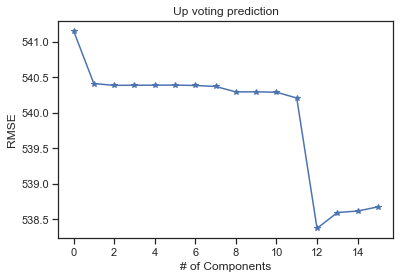

In [79]:
# error in absolte terms which is around 5.5 %
plt.plot(RMSE, '-*')
plt.xlabel('# of Components')
plt.ylabel('RMSE')
plt.title('Up voting prediction');

## Random Forest Regressor

In [80]:
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train,y_train)
y_pred_rf = rf_model.predict(X_test)


### Error calculation for Random Forest Regressor on the test set

In [81]:
r2_train_rf = r2_score(y_test,y_pred_rf) # R2 score  on test set
rmse_train_rf =np.sqrt(mean_squared_error(y_test,y_pred_rf))
print("R2 Score for Train Set of Random Forest Model: ",(r2_train_rf)/100) # root mean sequre error on test set as percentage
print("RMSE for Train Set of Random Forest Model: ",(rmse_train_rf)/100) # root mean sequre error on test set as percentage

#R2 Score for Random Forest  is -0.04

R2 Score for Train Set of Random Forest Model:  -0.00045400418631587726
RMSE for Train Set of Random Forest Model:  5.550210451680812
